In [11]:
import numpy as np
import pandas as pd
import sys, codecs
import dask.dataframe as dd
import dask.array as da
import dask.bag as db
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.cluster import KMeans
import math
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from gensim.models.phrases import Phrases,Phraser
from gensim.models import Word2Vec
from nltk.stem import WordNetLemmatizer
import ast
import os    
import glob
import datetime
import umap
import geopandas as gpd
from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW
from mgwr.utils import shift_colormap, truncate_colormap
from textblob import TextBlob
import matplotlib.pyplot as plt

In [12]:
# 连接input csv
citys=['B']
# citys=['M']
firstflag=0
for city in citys:
    path=r'UBDC/sale_2020/'+city+'/'
    filepath=path+'*dim*.csv'
    #     print(filepath)
    for csvname in glob.glob(filepath):
        print(csvname)
        if firstflag==0:
            df_input=pd.read_csv(csvname)
            firstflag=1
        else:
            df_input=df_input.append(pd.read_csv(csvname),ignore_index=True)
df_input=df_input.fillna(0)
df_input_store=df_input[['polarity','subjectivity','lon','lat']]
df_input.drop(['lon','lat','Unnamed: 0','Unnamed: 0.1','bed_flag','polarity','subjectivity'],axis=1,inplace=True)
list_county=[w for w in df_input.columns if w[0:6]=='county']
df_input.drop(list_county,axis=1,inplace=True)
df_input=df_input.astype(int)
df_input=pd.concat([df_input,df_input_store],axis=1)
df_input.drop(df_input[df_input['price_last']==0].index,axis=0,inplace=True)
df_input.reset_index(drop=True,inplace=True)

UBDC/sale_2020/B/00010_diminput.csv
UBDC/sale_2020/B/00009_diminput.csv
UBDC/sale_2020/B/00007_diminput.csv
UBDC/sale_2020/B/00006_diminput.csv
UBDC/sale_2020/B/00001_diminput.csv
UBDC/sale_2020/B/00000_diminput.csv
UBDC/sale_2020/B/00005_diminput.csv
UBDC/sale_2020/B/00008_diminput.csv
UBDC/sale_2020/B/00004_diminput.csv
UBDC/sale_2020/B/00002_diminput.csv
UBDC/sale_2020/B/00003_diminput.csv


In [3]:
df_input

,end_date,price_last,num_bed_last,num_floors_max,num_bath_max,num_reception_max,glaze,radiator,heating,light,...,lad20nm_Wychavon,property_type_Farmhouse,property_type_Retail premises,property_type_Equestrian property,property_type_Lodge,property_type_Villa,polarity,subjectivity,lon,lat
0,497,240000,2,0,1,2,1,0,0,0,...,0,0,0,0,0,0,0.221595,0.412174,-1.890188,52.568928
1,342,375000,3,0,1,1,0,1,0,1,...,0,0,0,0,0,0,0.098009,0.447759,-1.897800,52.422905
2,268,175000,3,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0.218476,0.451238,-1.899657,52.290787
3,384,379950,4,0,1,1,1,1,0,1,...,0,0,0,0,0,0,0.070944,0.352337,-1.846122,52.428340
4,416,425000,3,0,1,2,0,0,0,0,...,0,0,0,0,0,0,0.167367,0.317626,-1.952199,52.417625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88261,78,500000,4,0,2,1,1,1,0,0,...,0,0,0,0,0,0,0.118939,0.375947,-1.846999,52.551025
88262,280,200000,2,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0.080201,0.246679,-1.942820,52.279380
88263,527,180000,3,0,2,1,1,0,0,0,...,0,0,0,0,0,0,0.054167,0.338141,-1.789408,52.477146
88264,547,200000,1,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0.115000,0.381944,-1.939126,52.430250


(270000.0, 300000.0)

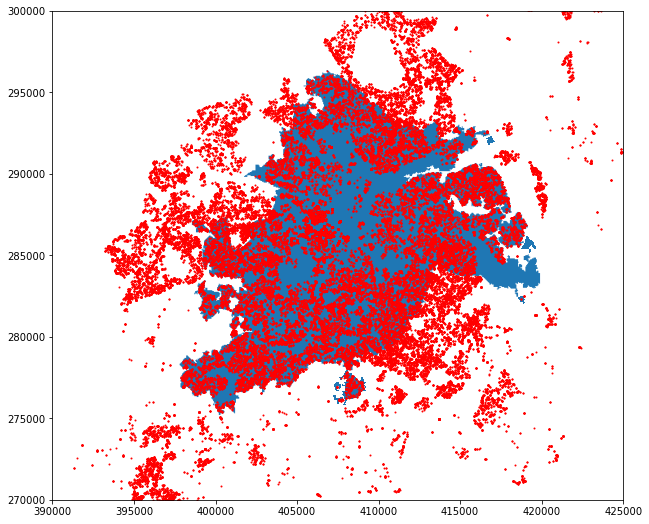

In [13]:
gdf = gpd.read_file('shapefile/Major_Towns_and_Cities_(December_2015)_Boundaries_V2.geojson')
bm=gdf[gdf['TCITY15NM']=='Birmingham']

bm=bm.to_crs("epsg:27700")
gdf_input=gpd.GeoDataFrame(df_input[['lon','lat']],geometry=gpd.points_from_xy(df_input.lon, df_input.lat, crs='epsg:4326'))
gdf_input=gdf_input.to_crs("epsg:27700")
# gdf_input[gdf_input]
# gdf_input=gpd.sjoin(gdf_input,bm[['geometry']], how="inner", op='intersects').reset_index()
# london_index=gdf_input['index']
# df_input=df_input.iloc[london_index]
# num0col=pd.DataFrame(df_input.sum()) #remove sum=0 columns
# col=num0col[num0col[0]==0].index
# df_input.drop(col,axis=1,inplace=True)
# df_input.reset_index(drop=True,inplace=True)
import matplotlib.pyplot as plt
f,ax = plt.subplots(figsize=(15,9))
bm.plot(ax=ax)
gdf_input.plot(color='red',markersize=1,ax=ax)
ax.set_xlim([390000,425000])
ax.set_ylim([270000,300000])

In [5]:
# train set and test set
random_state_split = 8
# position_col=[x for x in df_input if x[0:4]=='lad2']
text_col=df_input.columns.tolist()[6:487]
train_x, test_x, train_y, test_y = train_test_split(df_input.drop(['price_last'], axis = 1), df_input.price_last, random_state=random_state_split)
train_x_g=train_x[['lon','lat']]
test_x_g=test_x[['lon','lat']]
train_x.drop(['lon','lat'],axis=1,inplace=True)
test_x.drop(['lon','lat'],axis=1,inplace=True)
train_x.reset_index(inplace=True,drop=True)
test_x.reset_index(inplace=True,drop=True)
train_y.reset_index(inplace=True,drop=True)
test_y.reset_index(inplace=True,drop=True)

lasso

In [6]:
%%time
lasso_model = Lasso( normalize=True)
lasso_model.fit(X=train_x, y=train_y)

CPU times: user 43 s, sys: 1min 49s, total: 2min 32s
Wall time: 20.1 s


Lasso(normalize=True)

In [34]:
lasso_model.score(X=train_x, y=train_y)

0.6323416845270312

In [35]:
lasso_model.score(X=test_x, y=test_y)

0.6207004515930337

In [7]:
%%time
from sklearn.linear_model import LassoCV
alphas = 10**np.linspace(- 3, 3, 100) 
lasso_cv = LassoCV(alphas = alphas, normalize= True, cv = 20, max_iter= 500000).fit(train_x, train_y)

CPU times: user 11min 9s, sys: 10min 57s, total: 22min 7s
Wall time: 8min 36s


In [8]:
# 0.5336699231206312
best_alpha=lasso_cv.alpha_
lasso_model = Lasso(max_iter=10e7, normalize=True, alpha = best_alpha)
lasso_model.fit(X=train_x, y=train_y)
print(lasso_model.score(train_x, train_y))

0.6334358874564198


In [37]:
best_alpha

NameError: name 'best_alpha' is not defined

In [14]:
# pd.set_option('display.max_rows', 200)
# df_coef_lasso = pd.DataFrame({"var": train_x.columns.values, "coef":lasso_model.coef_})
# useless_var=df_coef_lasso[df_coef_lasso.coef==0]['var'].values
useless_var=['dining', 'company', 'ceramic', 'superb', 'reserve', 'kingfisher',
       'lot', 'effort_verify', 'oven', 'supply_nigel', 'character',
       'proxy_telephone', 'auction_livestreamed',
       'property_type_Semi-detached house', 'lad20nm_Birmingham']

continue connect data

In [31]:
df_input=df_input.rename(columns={'end_date':'date_since_2019','num_bed_last':'num_bed',
'num_floors_max':'num_floors',
 'num_bath_max':'num_bath',
 'num_reception_max':'num_reception',
'polarity':"sentiment_polarity",
 'subjectivity':'sentiment_subjectivity'})
# useless_var=['situated', 'stunning', 'local', 'tap', 'finish', 'mixer', 'view',
#        'internal', 'unique', 'guide', 'precise_advise', 'mention_agree',
#        'regard', 'heathrow_airport', 'excess', 'purchaser', 'national',
#        'vinyl', 'marble', 'property_type_Maisonette',
#        'property_type_Restaurant/cafe', 'lad20nm_Epping Forest',
#        'property_type_Office', 'property_type_Industrial',
#        'lad20nm_Hertsmere', 'lad20nm_Three Rivers',
#        'lad20nm_Buckinghamshire']
df_input.drop(useless_var,axis=1,inplace=True)
notext_index=df_input[df_input.iloc[:,5:506-15+1+2].T.sum()==0].index #去掉单词列全为零的行
df_input.drop(notext_index,axis=0,inplace=True)

KeyError: "['dining' 'company' 'ceramic' 'superb' 'reserve' 'kingfisher' 'lot'\n 'effort_verify' 'oven' 'supply_nigel' 'character' 'proxy_telephone'\n 'auction_livestreamed' 'property_type_Semi-detached house'\n 'lad20nm_Birmingham'] not found in axis"

In [22]:
df_input.to_csv('bm_dim1.csv',index=False) #去掉lasso的无用变量
df_input[['lon','lat']].to_csv('bm_dim_lonlat1.csv',index=False)

In [27]:
# nosen
# train set and test set
random_state_split = 8
# position_col=[x for x in df_input if x[0:4]=='lad2']
text_col=df_input.columns.tolist()[6:506-len(useless_var)+1+2]
train_x_notext, test_x_notext, train_y_notext, test_y_notext = train_test_split(df_input.drop(['price_last','sentiment_polarity','sentiment_subjectivity'], axis = 1), df_input.price_last, random_state=random_state_split)
train_x_g=train_x_notext[['lon','lat']]
test_x_g=test_x_notext[['lon','lat']]
train_x_notext.drop(['lon','lat'],axis=1,inplace=True)
test_x_notext.drop(['lon','lat'],axis=1,inplace=True)
train_x_notext.reset_index(inplace=True,drop=True)
test_x_notext.reset_index(inplace=True,drop=True)
train_y_notext.reset_index(inplace=True,drop=True)
test_y_notext.reset_index(inplace=True,drop=True)

In [25]:
# notext+sen
# train set and test set
random_state_split = 8
# position_col=[x for x in df_input if x[0:4]=='lad2']
text_col=df_input.columns.tolist()[6:506-15+1+2]
train_x_notext, test_x_notext, train_y_notext, test_y_notext = train_test_split(df_input.drop(['price_last','sentiment_polarity','sentiment_subjectivity']+text_col, axis = 1), df_input.price_last, random_state=random_state_split)
train_x_g=train_x_notext[['lon','lat']]
test_x_g=test_x_notext[['lon','lat']]
train_x_notext.drop(['lon','lat'],axis=1,inplace=True)
test_x_notext.drop(['lon','lat'],axis=1,inplace=True)
train_x_notext.reset_index(inplace=True,drop=True)
test_x_notext.reset_index(inplace=True,drop=True)
train_y_notext.reset_index(inplace=True,drop=True)
test_y_notext.reset_index(inplace=True,drop=True)

In [18]:
# notext
# train set and test set
random_state_split = 8
# position_col=[x for x in df_input if x[0:4]=='lad2']
text_col=df_input.columns.tolist()[6:506-len(useless_var)+1+2]
train_x_notext, test_x_notext, train_y_notext, test_y_notext = train_test_split(df_input.drop(['price_last']+text_col, axis = 1), df_input.price_last, random_state=random_state_split)
train_x_g=train_x_notext[['lon','lat']]
test_x_g=test_x_notext[['lon','lat']]
train_x_notext.drop(['lon','lat'],axis=1,inplace=True)
test_x_notext.drop(['lon','lat'],axis=1,inplace=True)
train_x_notext.reset_index(inplace=True,drop=True)
test_x_notext.reset_index(inplace=True,drop=True)
train_y_notext.reset_index(inplace=True,drop=True)
test_y_notext.reset_index(inplace=True,drop=True)

In [19]:
%%time
lasso_model = Lasso( normalize=True)
lasso_model.fit(X=train_x_notext, y=train_y_notext)
print(lasso_model.score(X=train_x_notext, y=train_y_notext),'\n',lasso_model.score(X=test_x_notext, y=test_y_notext))

0.5386405658070414 
 0.5263633766426046
CPU times: user 181 ms, sys: 461 ms, total: 643 ms
Wall time: 84.3 ms


In [42]:
%%time
lasso_model = Lasso( normalize=True)
lasso_model.fit(X=train_x, y=train_y)
print(lasso_model.score(X=train_x, y=train_y),'\n',lasso_model.score(X=test_x, y=test_y))

0.6323416845270312 
 0.6207004515930337
CPU times: user 41.8 s, sys: 1min 39s, total: 2min 21s
Wall time: 9.24 s


regression tree

In [23]:
# train set and test set
random_state_split = 8
# position_col=[x for x in df_input if x[0:4]=='lad2']
text_col=df_input.columns.tolist()[6:506-len(useless_var)+1]
train_x, test_x, train_y, test_y = train_test_split(df_input.drop(['price_last'], axis = 1), df_input.price_last, random_state=random_state_split)
train_x_g=train_x[['lon','lat']]
test_x_g=test_x[['lon','lat']]
train_x.drop(['lon','lat'],axis=1,inplace=True)
test_x.drop(['lon','lat'],axis=1,inplace=True)
train_x.reset_index(inplace=True,drop=True)
test_x.reset_index(inplace=True,drop=True)
train_y.reset_index(inplace=True,drop=True)
test_y.reset_index(inplace=True,drop=True)

In [28]:
from sklearn.tree import DecisionTreeRegressor
reg_tree = DecisionTreeRegressor(random_state=8)
# if you don't remember the meaning of random_state, check out the lastest clustering workshop on Moodle
reg_tree.fit(train_x, train_y)
print("R2 on the training data:")
print(reg_tree.score(X=train_x, y=train_y))
print("R2 on the testing data:")
print(reg_tree.score(X=test_x, y=test_y))
from sklearn.metrics import mean_squared_error
print("RMSE on the training data:")
print(mean_squared_error(train_y, reg_tree.predict(train_x), squared=False))
print("RMSE on the testing data:")
print(mean_squared_error(test_y, reg_tree.predict(test_x), squared=False))

R2 on the training data:
0.9936962859274051
R2 on the testing data:
0.8080193847683099
RMSE on the training data:
15663.571300907755
RMSE on the testing data:
86885.08309575621


In [32]:
train_x

,date_since_2019,num_bed,num_floors,num_bath,num_reception,glaze,radiator,heating,light,central,...,lad20nm_Walsall,lad20nm_Warwick,lad20nm_Wychavon,property_type_Farmhouse,property_type_Retail premises,property_type_Equestrian property,property_type_Lodge,property_type_Villa,sentiment_polarity,sentiment_subjectivity
0,512,4,0,2,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.198972,0.453355
1,329,2,0,1,1,1,1,1,0,1,...,0,0,0,0,0,0,0,0,0.107960,0.342143
2,547,5,0,2,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.107318,0.340286
3,212,3,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,-0.011541,0.230390
4,413,4,0,2,2,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0.097946,0.268768
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66188,505,3,0,1,1,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0.121629,0.403581
66189,388,4,0,1,2,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0.055882,0.192157
66190,440,2,0,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0.007986,0.274377
66191,547,2,0,1,1,1,1,0,1,1,...,1,0,0,0,0,0,0,0,0.023723,0.275195


In [35]:
# notext
# train set and test set 
random_state_split = 8
# position_col=[x for x in df_input if x[0:4]=='lad2']
text_col=df_input.columns.tolist()[6:506-len(useless_var)+1]
train_x, test_x, train_y, test_y = train_test_split(df_input.drop(['price_last']+text_col, axis = 1), df_input.price_last, random_state=random_state_split)
train_x_g=train_x[['lon','lat']]
test_x_g=test_x[['lon','lat']]
train_x.drop(['lon','lat'],axis=1,inplace=True)
test_x.drop(['lon','lat'],axis=1,inplace=True)
train_x.reset_index(inplace=True,drop=True)
test_x.reset_index(inplace=True,drop=True)
train_y.reset_index(inplace=True,drop=True)
test_y.reset_index(inplace=True,drop=True)

In [29]:
from sklearn.tree import DecisionTreeRegressor
reg_tree = DecisionTreeRegressor(random_state=8)
# if you don't remember the meaning of random_state, check out the lastest clustering workshop on Moodle
reg_tree.fit(train_x_notext, train_y_notext)
print("R2 on the training data:")
print(reg_tree.score(X=train_x_notext, y=train_y_notext))
print("R2 on the testing data:")
print(reg_tree.score(X=test_x_notext, y=test_y_notext))
# from sklearn.metrics import mean_squared_error
# print("RMSE on the training data:")
# print(mean_squared_error(train_y, reg_tree.predict(train_x), squared=False))
# print("RMSE on the testing data:")
# print(mean_squared_error(test_y, reg_tree.predict(test_x), squared=False))

R2 on the training data:
0.9934363622515507
R2 on the testing data:
0.8323984590906117


random forest

In [34]:
%%time
from sklearn.ensemble import RandomForestRegressor
randomState_rf = 8
rf = RandomForestRegressor(n_estimators=200, random_state=randomState_rf,n_jobs=-1)
rf.fit(train_x,train_y)
print("R2 on the training data:")
print(rf.score(train_x,train_y))
print("R2 on the testing data:")
print(rf.score(test_x,test_y))

R2 on the training data:
0.9803223613976643
R2 on the testing data:
0.8974785635428648
CPU times: user 1h 6min 41s, sys: 9.08 s, total: 1h 6min 50s
Wall time: 4min 16s


In [68]:
%%time
# 没文本变量的

from sklearn.ensemble import RandomForestRegressor
randomState_rf = 8
rf = RandomForestRegressor(n_estimators=200, random_state=randomState_rf,n_jobs=-1)
rf.fit(train_x_notext,train_y_notext)
print("R2 on the training data:")
print(rf.score(train_x_notext,train_y_notext))
print("R2 on the testing data:")
print(rf.score(test_x_notext,test_y_notext))

R2 on the training data:
0.9351557747595133
R2 on the testing data:
0.8012887840852952
CPU times: user 57.5 s, sys: 412 ms, total: 57.9 s
Wall time: 3.9 s


                              Importance
Feature                                 
num_bed                         0.728053
property_type_Detached house    0.265322
num_bath                        0.160586
sentiment_polarity              0.097902
num_reception                   0.089319
...                                  ...
day                            -0.000584
wonderful                      -0.000702
internal                       -0.001142
communal                       -0.002535
property_type_Land             -0.003240

[531 rows x 1 columns]


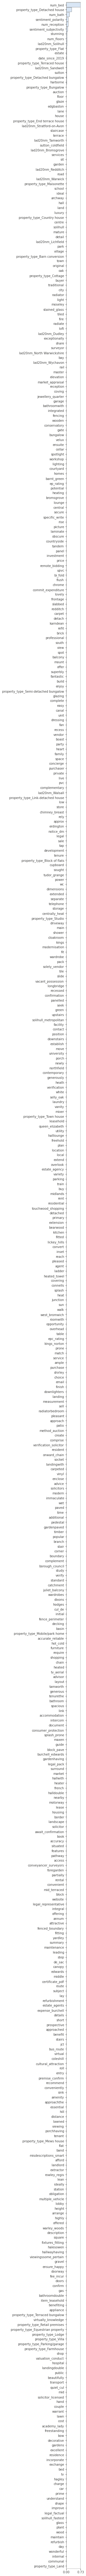

In [35]:
import rfpimp
imp = rfpimp.importances(rf, test_x, test_y) # permutation
print(imp)
viz = rfpimp.plot_importances(imp)
viz.view()

In [36]:
imp[0:50].to_csv('b_sig50.csv')

In [49]:
%%time
# cross va
from sklearn import model_selection
from sklearn.ensemble import RandomForestRegressor
X_train_val = pd.concat([train_x,test_x])
y_train_val = pd.concat([train_y,test_y])
# values of n_estimators
parameters = {'n_estimators':[10,20,30,40,50,70,100,200]}
rf = RandomForestRegressor(n_jobs=-1)

# cv=5 by default, which means 5-fold cross-validation
clf = model_selection.GridSearchCV(rf, parameters)

clf.fit(X_train_val, y_train_val)

# we can query the best parameter value and its accuracy score
print ("The best parameter value is: ")
print (clf.best_params_)
print ("The best score is: ")
print (clf.best_score_)

The best parameter value is: 
{'n_estimators': 200}
The best score is: 
0.812334174057893
CPU times: user 28min 41s, sys: 9.28 s, total: 28min 50s
Wall time: 20min 41s


dim forgwr

In [152]:
gwr_x=df_input.drop(['price_last'],axis=1)
gwr_y=df_input[['price_last']]
gwr_xy=df_input[['lon','lat']]

In [112]:
gwr_x

,date_since_2019,num_bed,num_bath,num_reception,sentiment_polarity,sentiment_subjectivity,E0,E1,E2,E3,E4,E5,E6,E7,E8,E9
0,342,3,1,1,0.098009,0.447759,6.569318,3.251033,3.467421,3.656219,2.965899,3.515040,-1.496311,3.756690,8.215664,9.720638
1,384,4,1,1,0.070944,0.352337,8.664263,6.906771,7.122852,5.141614,2.154643,6.154348,1.734485,6.202691,5.529320,6.583726
2,416,3,1,2,0.167367,0.317626,8.739491,4.907026,1.333675,7.148592,4.963130,4.149731,3.317683,2.661848,4.598044,3.886984
3,42,3,1,1,0.144149,0.379119,10.410891,6.562410,8.459810,4.005907,3.508249,6.303863,3.834902,6.653435,6.545863,7.054929
4,401,5,1,2,0.136217,0.402067,9.728164,6.708051,7.239527,3.232992,2.743706,5.668015,3.954279,6.007848,6.094866,6.522503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42810,244,3,1,1,0.390385,0.537179,7.956109,3.567104,8.674326,5.178532,6.167826,5.201426,5.919116,-6.066750,5.164315,4.370794
42811,427,3,2,1,0.242014,0.445139,8.407111,5.843412,3.728468,6.912776,4.959588,4.369352,3.697247,2.945975,4.784785,4.880745
42812,275,1,1,1,0.123333,0.347778,5.783245,6.439312,5.913247,9.138386,8.657790,2.918574,5.106945,4.584164,5.199474,5.440720
42813,527,3,2,1,0.054167,0.338141,9.136870,6.799948,5.506070,4.916863,3.785830,5.509509,4.334521,4.174864,4.544577,6.166924


In [172]:
df_toUMAP=gwr_x.drop(['date_since_2019',
 'num_bed',
#  'num_floors',
 'num_bath',
 'num_reception','sentiment_polarity',
 'sentiment_subjectivity'],axis=1)
#  ,'luxury' ,'ideal', 'rare'
reducer = umap.UMAP(
    n_neighbors=25,
    min_dist=0.01,
    n_components=5,
    random_state=8)

arr_UMAP=reducer.fit_transform(df_toUMAP)

df_x_10=pd.DataFrame(arr_UMAP,columns= ['E'+str(x) for x in np.arange(0,5)])
gwr_x=pd.concat([gwr_x[['date_since_2019',
 'num_bed',
#  'num_floors',
 'num_bath',
 'num_reception','sentiment_polarity',
 'sentiment_subjectivity']],df_x_10],axis=1) 

gwr

In [173]:
# gwr input
# train_x=pd.read_csv('train_x.csv')[0:30000]
# train_y=pd.read_csv('train_y.csv')[0:30000]
# train_x_g=pd.read_csv('train_x_g.csv')[0:30000]
train_cor=list(zip(gwr_xy['lon'],gwr_xy['lat']))
# test_cor=list(zip(test_x['lon'],test_x['lat']))
train_x_g1=gwr_x.values
# test_x_g=test_x[gwr_var].values
train_y_g1 =gwr_y.values.reshape((-1,1))
# test_y_g =test_y.values.reshape((-1,1))
# train_cor1=train_cor[0:5000]
# train_y_g1=train_y_g[0:5000]
# train_x_g1=train_x_g[0:5000]

In [166]:
gwr_x

,date_since_2019,num_bed,num_bath,num_reception,sentiment_polarity,sentiment_subjectivity,E0,E1,E2
0,342,3,1,1,0.098009,0.447759,5.806257,-2.567594,10.775678
1,384,4,1,1,0.070944,0.352337,-4.089027,3.084945,14.095291
2,416,3,1,2,0.167367,0.317626,-3.604298,-4.441895,4.990170
3,42,3,1,1,0.144149,0.379119,-6.112242,-3.564593,1.991172
4,401,5,1,2,0.136217,0.402067,0.531482,1.793830,9.866020
...,...,...,...,...,...,...,...,...,...
42810,244,3,1,1,0.390385,0.537179,-1.763864,-3.509973,15.404408
42811,427,3,2,1,0.242014,0.445139,1.563925,7.818437,12.739644
42812,275,1,1,1,0.123333,0.347778,6.661758,12.283540,8.405149
42813,527,3,2,1,0.054167,0.338141,3.730889,14.058499,3.001612


In [175]:
%%time 
# bm 40000 116
gwr_selector = Sel_BW(train_cor[0:20000], train_y_g1[0:20000], train_x_g1[0:20000])
gwr_bw = gwr_selector.search()
print('1')
gwr_results = GWR(train_cor[0:20000], train_y_g1[0:20000], train_x_g1[0:20000],gwr_bw).fit()

1
CPU times: user 1h 43min 30s, sys: 4h 23min 56s, total: 6h 7min 27s
Wall time: 22min 59s


In [177]:
# 回归参数
var_names=['sentiment_polarity','sentiment_subjectivity']
gwr_coefficent=pd.DataFrame(gwr_results.params[:,4:6],columns=var_names)
# 回归参数显著性
# gwr_flter_t=pd.DataFrame(gwr_results.filter_tvals())
# 将点数据回归结果放到面上展示
# 主要是由于两个文件中的记录数不同，矢量面中的记录比csv中多几条，因此需要将没有参加gwr的区域去掉

georgia_data_geo=gpd.GeoDataFrame(gwr_coefficent,geometry=gpd.points_from_xy(gwr_xy[0:20000].lon, gwr_xy[0:20000].lat, crs='epsg:4326'))

# 将回归参数与面数据结合
# georgia_shp_geo=gp.sjoin(georgia_shp,georgia_data_geo, how="inner", op='intersects').reset_index()
georgia_data_geo=georgia_data_geo.to_crs("epsg:27700")
georgia_data_geo['lon']=gwr_xy[0:20000].lon
georgia_data_geo['lat']=gwr_xy[0:20000].lat

In [178]:
gwr_flter_t=pd.DataFrame(gwr_results.filter_tvals())
gwr_flter_t[gwr_flter_t[4]!=0]
georgia_data_geo_fil=georgia_data_geo.iloc[gwr_flter_t[gwr_flter_t[4]!=0].index.tolist()]
georgia_data_geo_fil.shape

(1801, 5)

In [170]:
georgia_data_geo_fil.to_csv('bm_gwr_pra1.csv')

In [150]:
train_x_g1[34950:35000]

array([[ 5.42000000e+02,  5.00000000e+00,  4.00000000e+00,
         1.00000000e+00,  9.28571429e-02,  3.67446634e-01,
         3.42484808e+00, -2.01717570e-01, -3.67370892e+00,
        -1.93291605e-01, -5.17126656e+00, -3.04200101e+00,
        -1.63450754e+00, -9.55181599e-01,  5.62445223e-01,
         3.33862472e+00],
       [ 4.34000000e+02,  4.00000000e+00,  1.00000000e+00,
         2.00000000e+00,  1.49942681e-01,  4.89651675e-01,
         3.01767087e+00, -5.00838995e+00,  3.14439273e+00,
        -4.50597095e+00, -8.90417337e-01, -7.35535741e-01,
         1.62177241e+00,  2.28964901e+00,  3.82650948e+00,
         1.48865497e+00],
       [ 3.84000000e+02,  2.00000000e+00,  2.00000000e+00,
         1.00000000e+00,  1.34523810e-01,  4.50613276e-01,
         6.77980947e+00,  5.15123749e+00, -7.68817723e-01,
         5.06745815e+00, -3.94898616e-02,  1.04525983e+00,
         3.01890790e-01,  6.86266363e-01, -3.94835496e+00,
         2.59518623e+00],
       [ 1.42000000e+02,  4.00000000e

In [176]:
%%time 
# london 20000 116
gwr_selector = Sel_BW(train_cor[20000:], train_y_g1[20000:], train_x_g1[20000:])
gwr_bw = gwr_selector.search()
print('1')
gwr_results1 = GWR(train_cor[20000:], train_y_g1[20000:], train_x_g1[20000:],gwr_bw).fit()

/opt/conda/envs/sds2021/lib/python3.9/site-packages/spglm/iwls.py:37: LinAlgWarning: Ill-conditioned matrix (rcond=2.00361e-37): result may not be accurate.
  xtx_inv_xt = linalg.solve(xtx, xT)
/opt/conda/envs/sds2021/lib/python3.9/site-packages/spglm/iwls.py:37: LinAlgWarning: Ill-conditioned matrix (rcond=9.84736e-38): result may not be accurate.
  xtx_inv_xt = linalg.solve(xtx, xT)
/opt/conda/envs/sds2021/lib/python3.9/site-packages/spglm/iwls.py:37: LinAlgWarning: Ill-conditioned matrix (rcond=1.11959e-36): result may not be accurate.
  xtx_inv_xt = linalg.solve(xtx, xT)
/opt/conda/envs/sds2021/lib/python3.9/site-packages/spglm/iwls.py:37: LinAlgWarning: Ill-conditioned matrix (rcond=7.73667e-37): result may not be accurate.
  xtx_inv_xt = linalg.solve(xtx, xT)
/opt/conda/envs/sds2021/lib/python3.9/site-packages/spglm/iwls.py:37: LinAlgWarning: Ill-conditioned matrix (rcond=3.50641e-36): result may not be accurate.
  xtx_inv_xt = linalg.solve(xtx, xT)
/opt/conda/envs/sds2021/lib/py

LinAlgError: Matrix is singular.

In [180]:
c1=georgia_data_geo_fil[georgia_data_geo_fil['sentiment_polarity']>40000]
c2=georgia_data_geo_fil[georgia_data_geo_fil['sentiment_polarity']<-40000]
df_clu=pd.concat([c1,c2]).reset_index(drop=True)
df_clu

,sentiment_polarity,sentiment_subjectivity,geometry,lon,lat
0,71789.000362,606346.173699,POINT (403381.998 284625.087),-1.951654,52.459564
1,143594.127006,225856.052196,POINT (404658.007 285919.098),-1.932857,52.471188
2,172994.762758,910428.819788,POINT (407059.021 291640.091),-1.897392,52.522594
3,63271.776392,19935.520354,POINT (406545.065 284018.198),-1.905114,52.454080
4,73488.984626,382861.707515,POINT (403435.030 281559.051),-1.950904,52.432000
...,...,...,...,...,...
1735,-116123.965697,299823.781915,POINT (406780.429 286495.162),-1.901601,52.476345
1736,-115745.305445,297923.171668,POINT (406780.024 286493.938),-1.901607,52.476334
1737,-56259.497507,-396167.793653,POINT (403842.027 284680.142),-1.944883,52.460056
1738,-72307.264613,-387240.180333,POINT (403914.990 284782.979),-1.943808,52.460980


In [284]:
msoas = gpd.read_file('https://github.com/jreades/i2p/blob/master/data/src/Middle_Layer_Super_Output_Areas__December_2011__EW_BGC_V2-shp.zip?raw=true')
gdf = gpd.read_file('shapefile/Major_Towns_and_Cities_(December_2015)_Boundaries_V2.geojson')
bm=gdf[gdf['TCITY15NM']=='Birmingham']
bm=bm.to_crs("epsg:27700")
bm['geometry'] = bm['geometry'].buffer(-400)
# bm_msoas = gpd.sjoin(bm,msoas,op='contains') 
bm_msoas = gpd.sjoin(msoas,bm,op='intersects') 
bm_msoas.drop(['index_right'],axis=1,inplace=True)
bm_msoas_join=gpd.sjoin(bm_msoas,georgia_data_geo_fil)
msoagrdf = bm_msoas_join.groupby('MSOA11NM').agg({'sentiment_polarity':['mean'],'sentiment_subjectivity':['mean']}).reset_index()
msoagrdf.columns=['MSOA11NM','sentiment_polarity_mean','sentiment_subjectivity_mean']
bm_msoas_mean=pd.merge(bm_msoas,msoagrdf,on='MSOA11NM')

In [296]:
# bm['geometry'] = bm['geometry'].buffer(200)
bm=gdf[gdf['TCITY15NM']=='Birmingham']
bm=bm.to_crs("epsg:27700")

In [275]:
delindex=[]
bm_msoas.reset_index(drop=True,inplace=True)
for count in range(bm_msoas.shape[0]):
    if bm_msoas['MSOA11NM'].iloc[count][0:6]!='Birmin':
        delindex.append(count)
    
bm_msoas.drop(delindex,axis=0,inplace=True)


In [299]:
df_clu=georgia_data_geo_fil

In [323]:
from sklearn.preprocessing import RobustScaler, MinMaxScaler
rs = RobustScaler(quantile_range=(10.0, 90.0))
raw = df_clu[['sentiment_polarity','lon','lat','sentiment_subjectivity']].copy()
normed = raw.copy()
for c in raw.columns.values:
    normed[c] = rs.fit_transform(raw[c].values.reshape(-1,1))
    print("The range of {} is [{}, {}]".format(c, normed[c].min(), normed[c].max()))
normed.head()
from sklearn.cluster import KMeans, DBSCAN
minPts = 5 # we set minPts as normed.shape[1] + 1 
epsilon = 0.1
dbsc = DBSCAN(eps=epsilon, min_samples=minPts)
dbsc.fit(normed)
cluster_nm = dbsc.labels_
df_clu['clu']=cluster_nm

The range of sentiment_polarity is [-1.9282753740762009, 1.8267576580716651]
The range of lon is [-1.14817344260539, 2.2532138839787894]
The range of lat is [-0.8255970647853845, 0.8535789914728813]
The range of sentiment_subjectivity is [-0.9361704681025449, 1.3618209293924135]


/opt/conda/envs/sds2021/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [307]:
df_clu

,sentiment_polarity,sentiment_subjectivity,geometry,lon,lat,clu
4,71789.000362,606346.173699,POINT (403381.998 284625.087),-1.951654,52.459564,0
11,143594.127006,225856.052196,POINT (404658.007 285919.098),-1.932857,52.471188,0
26,172994.762758,910428.819788,POINT (407059.021 291640.091),-1.897392,52.522594,1
29,63271.776392,19935.520354,POINT (406545.065 284018.198),-1.905114,52.454080,2
39,73488.984626,382861.707515,POINT (403435.030 281559.051),-1.950904,52.432000,2
...,...,...,...,...,...,...
19910,66024.086869,-202121.139608,POINT (403659.982 283856.202),-1.947571,52.452650,0
19921,46743.700088,83049.528046,POINT (403976.378 286036.646),-1.942890,52.472250,0
19940,50301.721543,-452422.267636,POINT (417190.000 285758.265),-1.748381,52.469494,14
19946,220872.133984,-432639.222876,POINT (406640.791 286233.571),-1.903662,52.473995,17


/opt/conda/envs/sds2021/lib/python3.9/site-packages/mgwr/utils.py:56: UserWarning: Trying to register the cmap 'shiftedcmap' which already exists.
  plt.register_cmap(cmap=new_cmap)


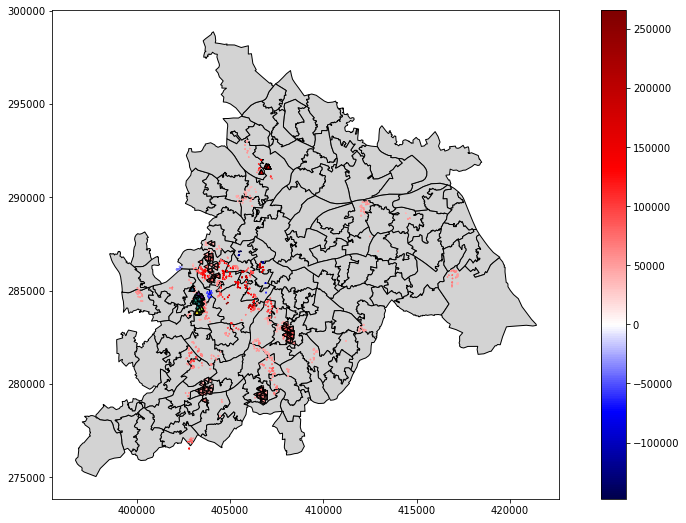

In [368]:
import matplotlib.pyplot as plt
f,ax = plt.subplots(figsize=(15,9))
cmap = plt.cm.seismic

vmin=georgia_data_geo_fil.sentiment_polarity.min()
vmax=georgia_data_geo_fil.sentiment_polarity.max()

# vmin1=ldn_msoas_mean.sentiment_polarity_mean.min()
# vmax1=ldn_msoas_mean.sentiment_polarity_mean.max()
cmap = shift_colormap(cmap,start=0.0, midpoint=1- vmax/(vmax + abs(vmin)))
# vmin=-vmax
sm = plt.cm.ScalarMappable(cmap=cmap,norm = plt . Normalize (vmin = vmin , vmax = vmax ))
sm1 = plt.cm.ScalarMappable(cmap=cmap,norm = plt . Normalize (vmin = -vmax , vmax = vmax ))
cmap=sm.cmap   
# sm1 = plt.cm.ScalarMappable(cmap=cmap,norm = plt . Normalize (vmin = vmin1 , vmax = vmax1 ))
# gdf[gdf['TCITY15NM']=='London'].plot(facecolor='none',ax=ax)

bm_msoas.plot(facecolor='none',color='lightgrey',ax=ax,edgecolor='black')
# bm.plot(facecolor='none',color='lightgrey',ax=ax,edgecolor='black')
# georgia_shp_geo.plot(column='cof_apartment',cmap='viridis', legend=True, marker='*', markersize=1, ax=ax)


# df_clu[df_clu['clu']==1].plot( column='sentiment_polarity',marker='s', markersize=20,cmap=cmap, 
#         vmin=vmin,vmax=vmax,ax=ax)
df_clu.plot(column='sentiment_polarity', marker='*', markersize=1,cmap=cmap,ax=ax)
df_clu[df_clu['clu']==0].plot(column='sentiment_polarity', marker='^', markersize=20,edgecolor='black',ax=ax)
df_clu[df_clu['clu']==2].plot( column='sentiment_polarity',marker='^', markersize=20,cmap=cmap, edgecolor='black',
        vmin=vmin,vmax=vmax,ax=ax)
df_clu[df_clu['clu']==8].plot( column='sentiment_polarity',marker='<', markersize=20,cmap=cmap, edgecolor='black',
        vmin=vmin,vmax=vmax,ax=ax)
df_clu[df_clu['clu']==12].plot( column='sentiment_polarity',marker='<', markersize=20,cmap=cmap, edgecolor='black',
        vmin=vmin,vmax=vmax,ax=ax)
df_clu[df_clu['clu']==13].plot( column='sentiment_polarity',marker='<', markersize=20,cmap=cmap, edgecolor='black',
        vmin=vmin,vmax=vmax,ax=ax)
df_clu[df_clu['clu']==23].plot( column='sentiment_polarity',marker='<', markersize=20,cmap=cmap, edgecolor='black',
        vmin=vmin,vmax=vmax,ax=ax)
# df_clu[df_clu['clu']==14].plot( column='sentiment_polarity',marker='>', markersize=20,cmap=cmap, 
#         vmin=vmin,vmax=vmax,ax=ax)
# ax.set_xlim([395000,422000])
# ax.set_xlim([400000,405000])
# ax.set_ylim([283000,287000])
cbar = f.colorbar(sm)



In [324]:
df_clu.groupby('clu').count()

,sentiment_polarity,sentiment_subjectivity,geometry,lon,lat
clu,,,,,
-1,261,261,261,261,261
0,118,118,118,118,118
1,31,31,31,31,31
2,98,98,98,98,98
3,22,22,22,22,22
4,14,14,14,14,14
5,19,19,19,19,19
6,8,8,8,8,8
7,46,46,46,46,46
